In [86]:
from pathlib import Path as pt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sigfig
import json

In [2]:
base_loc1 = pt(r'/Users/aravindhnivas/Documents/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/')
base_loc2 = pt(r'/Users/aravindhnivas/Documents/ML-properties/[CRITICAL CONSTANTS OF ORGANIC COMPOUNDS]/')

processed_data_dirs = [
    base_loc1 / 'tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data',
    base_loc1 / 'tbp_C_processed_data/analysis_data/filtered/tbp_topelements_processed_data',
    base_loc1 / 'vp_kPa_25C_filtered_ydata_processed_data/analysis_data/filtered/vp_kPa_25C_topelements_processed_data',
    base_loc2 / 'Pc_MPa_processed_data',
    base_loc2 / 'Tc_K_processed_data'
]

plots_dir = pt('/Users/aravindhnivas/Documents/ML-properties/plots/')

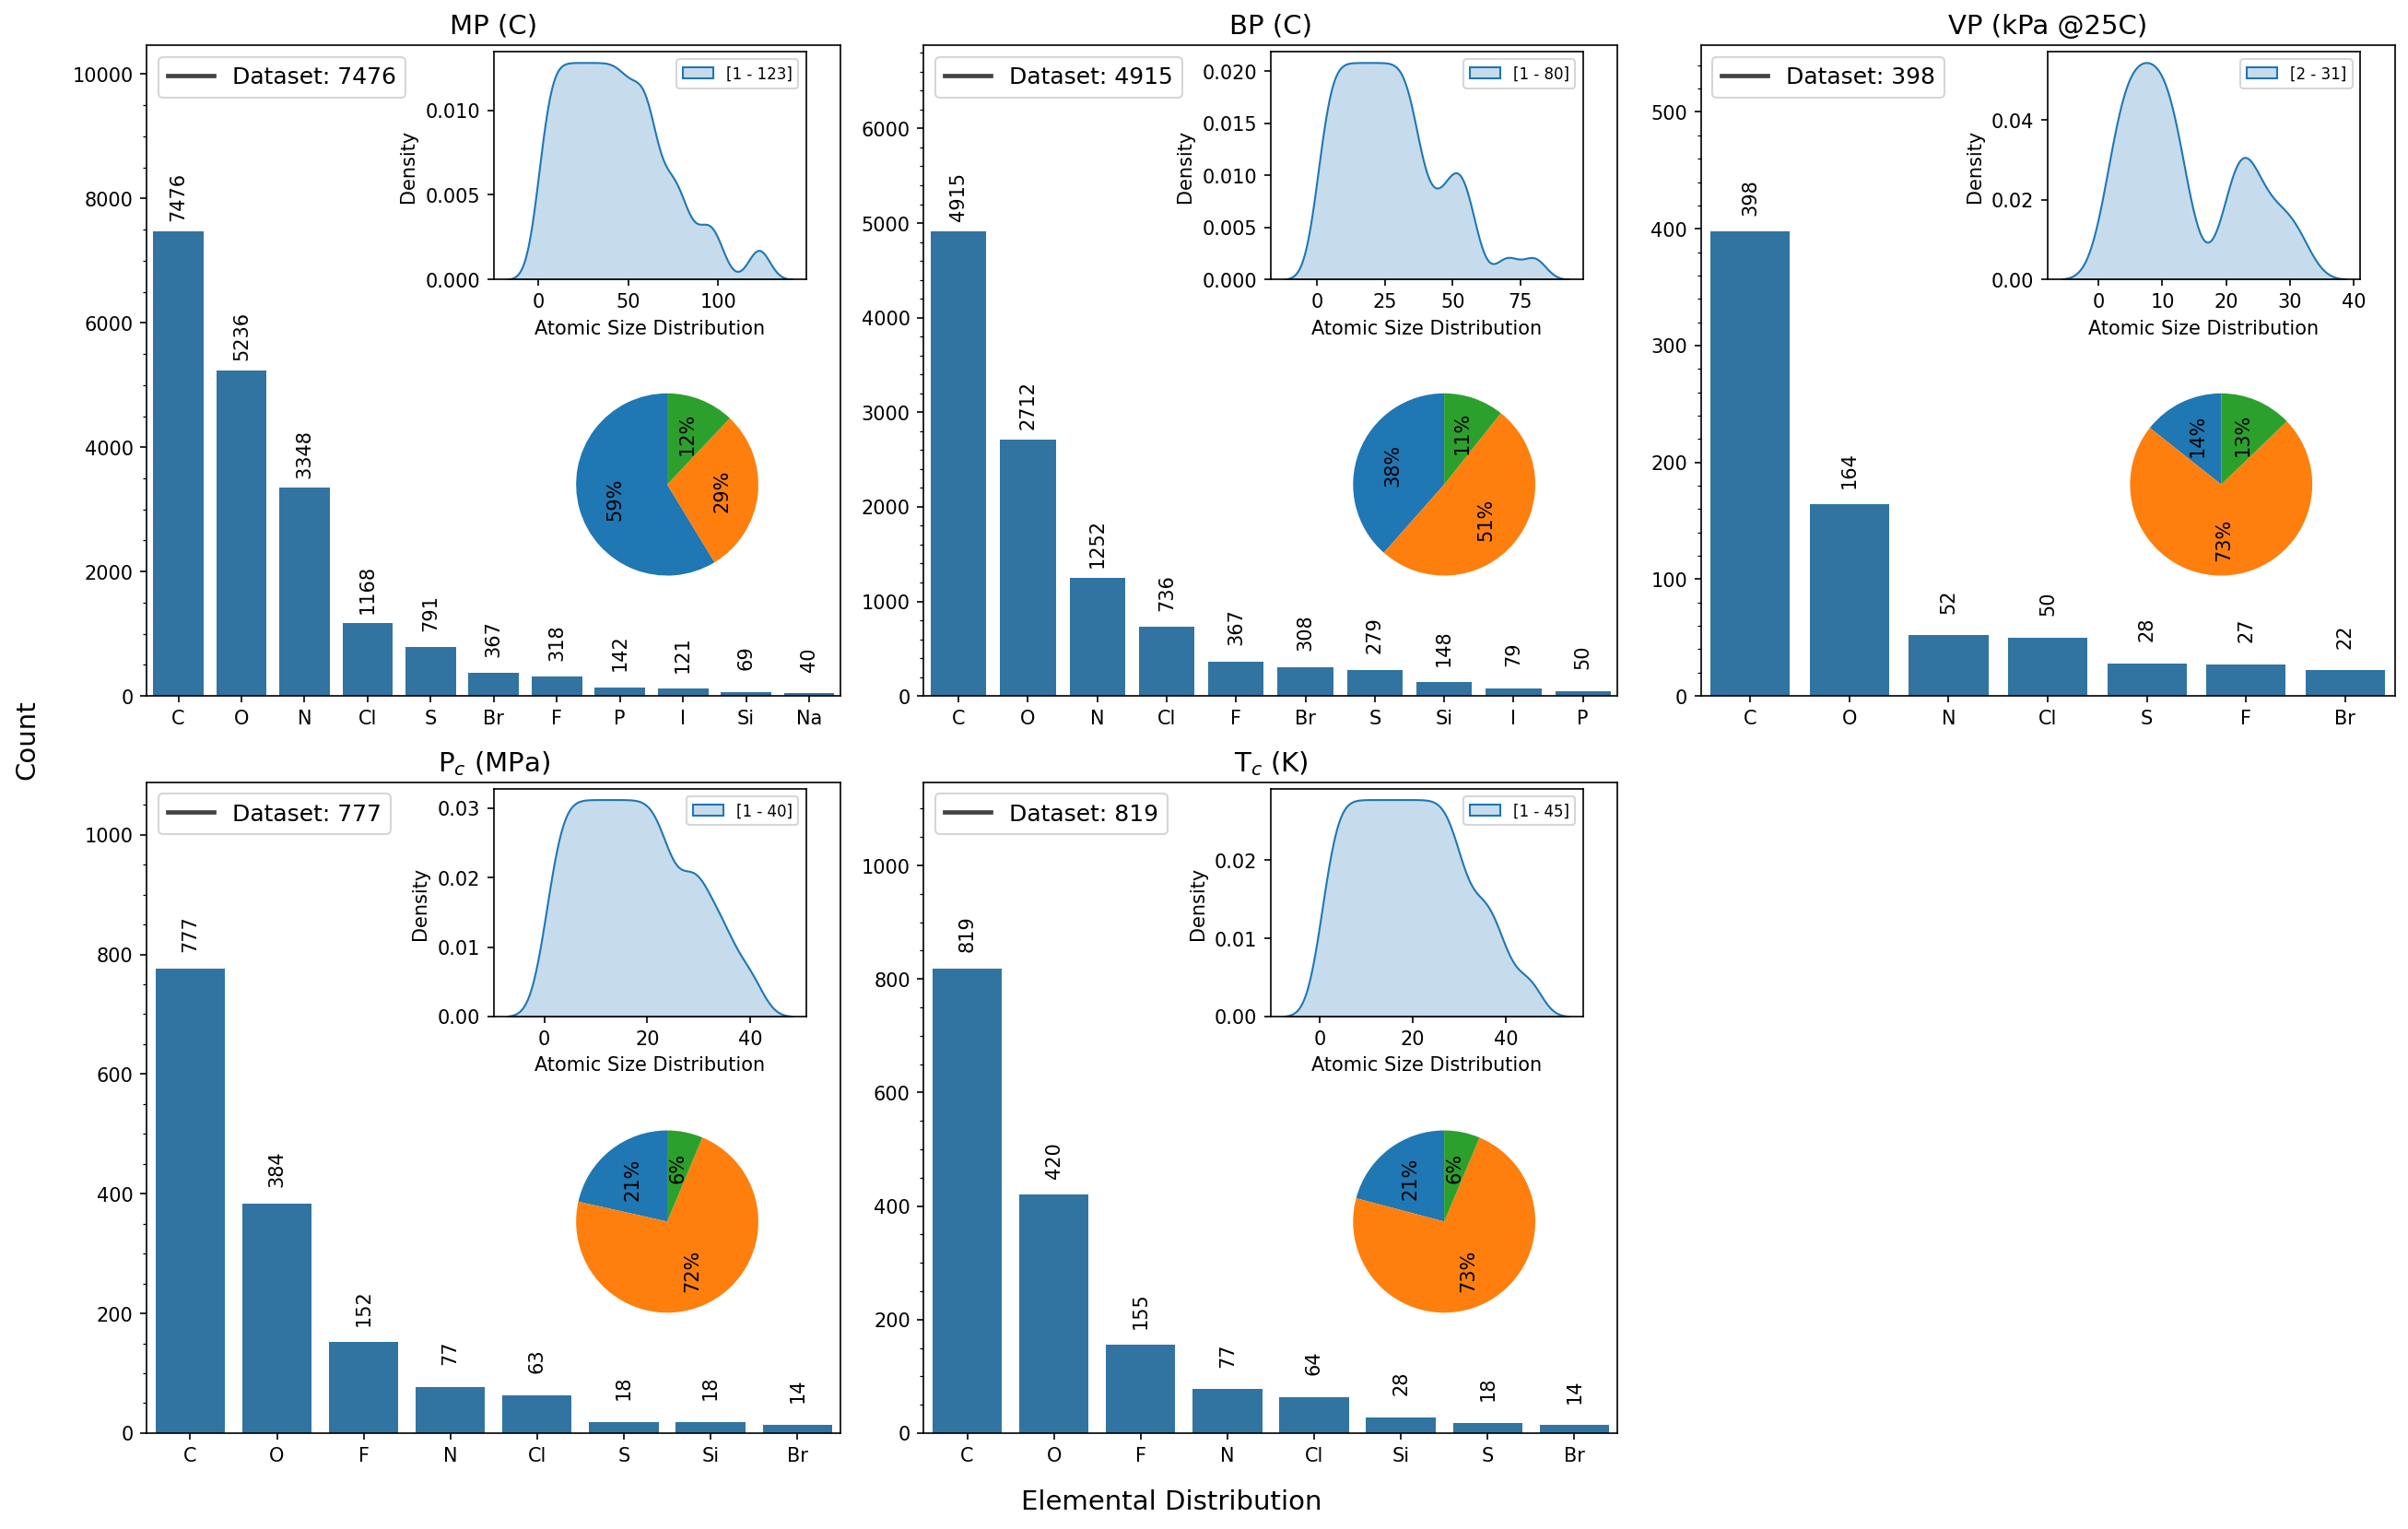

In [41]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

titles = [
    'MP (C)', 'BP (C)', 'VP (kPa @25C)', 'P$_c$ (MPa)', 'T$_c$ (K)'
]

total_counts = [7476, 4915, 398, 777, 819]

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    
    analysis_file = data_dir / 'analysis_data/elemental_distribution.csv'
    df_elemental_distribution = pd.read_csv(analysis_file)
    
    # remove counts < 10
    df_elemental_distribution = df_elemental_distribution[df_elemental_distribution['Count'] >= 10]
    
    sns.barplot(data=df_elemental_distribution, x='Element', y='Count', ax=axes[i], legend=False)
    axes[i].set_xlabel('')  # Remove individual X labels
    axes[i].set_ylabel('')  # Remove individual Y labels
    
    _title = f'Dataset: {total_counts[i]}'
    # axes[i].set_title(f'{titles[i]} ({_title})', fontsize=14)  # Set individual titles
    axes[i].set_title(titles[i], fontsize=14)  # Set individual titles
    axes[i].legend([_title], loc='upper left', fontsize=12)
    
    # Add count numbers on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            rotation='vertical',
            xytext=(0, 18),  # 9 points vertical offset
            textcoords='offset points'
        )
    
    # increase y-axis limits by 10% to avoid cutting off the top of the bars
    axes[i].set_ylim(0, 1.4 * df_elemental_distribution['Count'].max())
    axes[i].yaxis.set_minor_locator(AutoMinorLocator())
    
    # inset the atomic size distribution plot
    atomic_size_distribution_file = data_dir / 'analysis_data/size_distribution.csv'
    df_atomic_size_distribution = pd.read_csv(atomic_size_distribution_file)
    # df_atomic_size_distribution - columns: 'No. of atoms', 'Count'
    
    # Create inset axes
    # [x0, y0, width, height]
    inset_ax = axes[i].inset_axes([0.5, 0.64, 0.45, 0.35])  # Adjust the position and size as needed
    sns.kdeplot(df_atomic_size_distribution['No. of atoms'], ax=inset_ax, bw_adjust=0.5, fill=True)
    inset_ax.set_xlabel('Atomic Size Distribution', fontsize=10)
    atomic_size_min = df_atomic_size_distribution['No. of atoms'].min()
    atomic_size_max = df_atomic_size_distribution['No. of atoms'].max()
    range_text = f'[{atomic_size_min} - {atomic_size_max}]'
    inset_ax.legend([range_text], loc='upper right', fontsize=8)
    
    inset_ax2 = axes[i].inset_axes([0.5, 0.15, 0.5, 0.35])
    
    df_structural_distribution = pd.read_csv(data_dir / 'analysis_data/structural_distribution.csv')
    inset_ax2.pie(
        df_structural_distribution['Count'], 
        # labels=df_structural_distribution['Structural Category'], 
        autopct='%.0f%%', 
        # autopct=autopct_format,
        startangle=90,
        # pctdistance=1.4
    )
    
    for text in inset_ax2.texts:
        text.set_rotation(text.get_rotation() + 90)
    
# Remove the last subplot (bottom-right) if it exists
if len(processed_data_dirs) < 6:
    fig.delaxes(axes[-1])
    
# Add common X and Y labels
fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig(plots_dir / 'elemental_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

<Axes: xlabel='Processed tmp/ºC', ylabel='Count'>

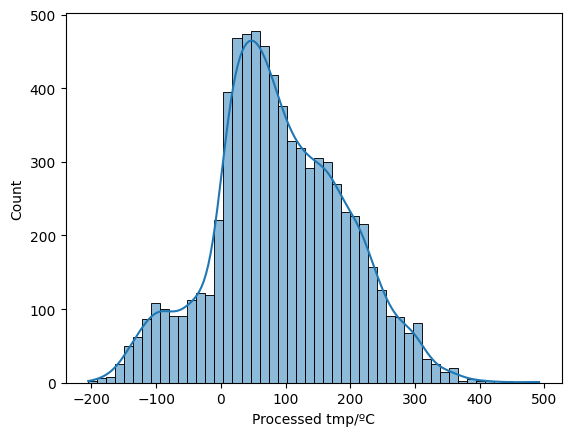

In [31]:
csv_file = list(processed_data_dirs[0].parent.glob('*.csv'))[0]
df = pd.read_csv(csv_file)
y = df['Processed tmp/ºC']
y.shape, csv_file.name
sns.histplot(y, bins=50, kde=True)

tmpC_topelements_processed_data (7476,) tmpC_topelements.csv
tbp_topelements_processed_data (4915,) tbp_topelements.csv
vp_kPa_25C_topelements_processed_data (398,) vp_kPa_25C_topelements.csv
Pc_MPa_processed_data (777,) Pc_MPa.csv
Tc_K_processed_data (819,) Tc_K.csv


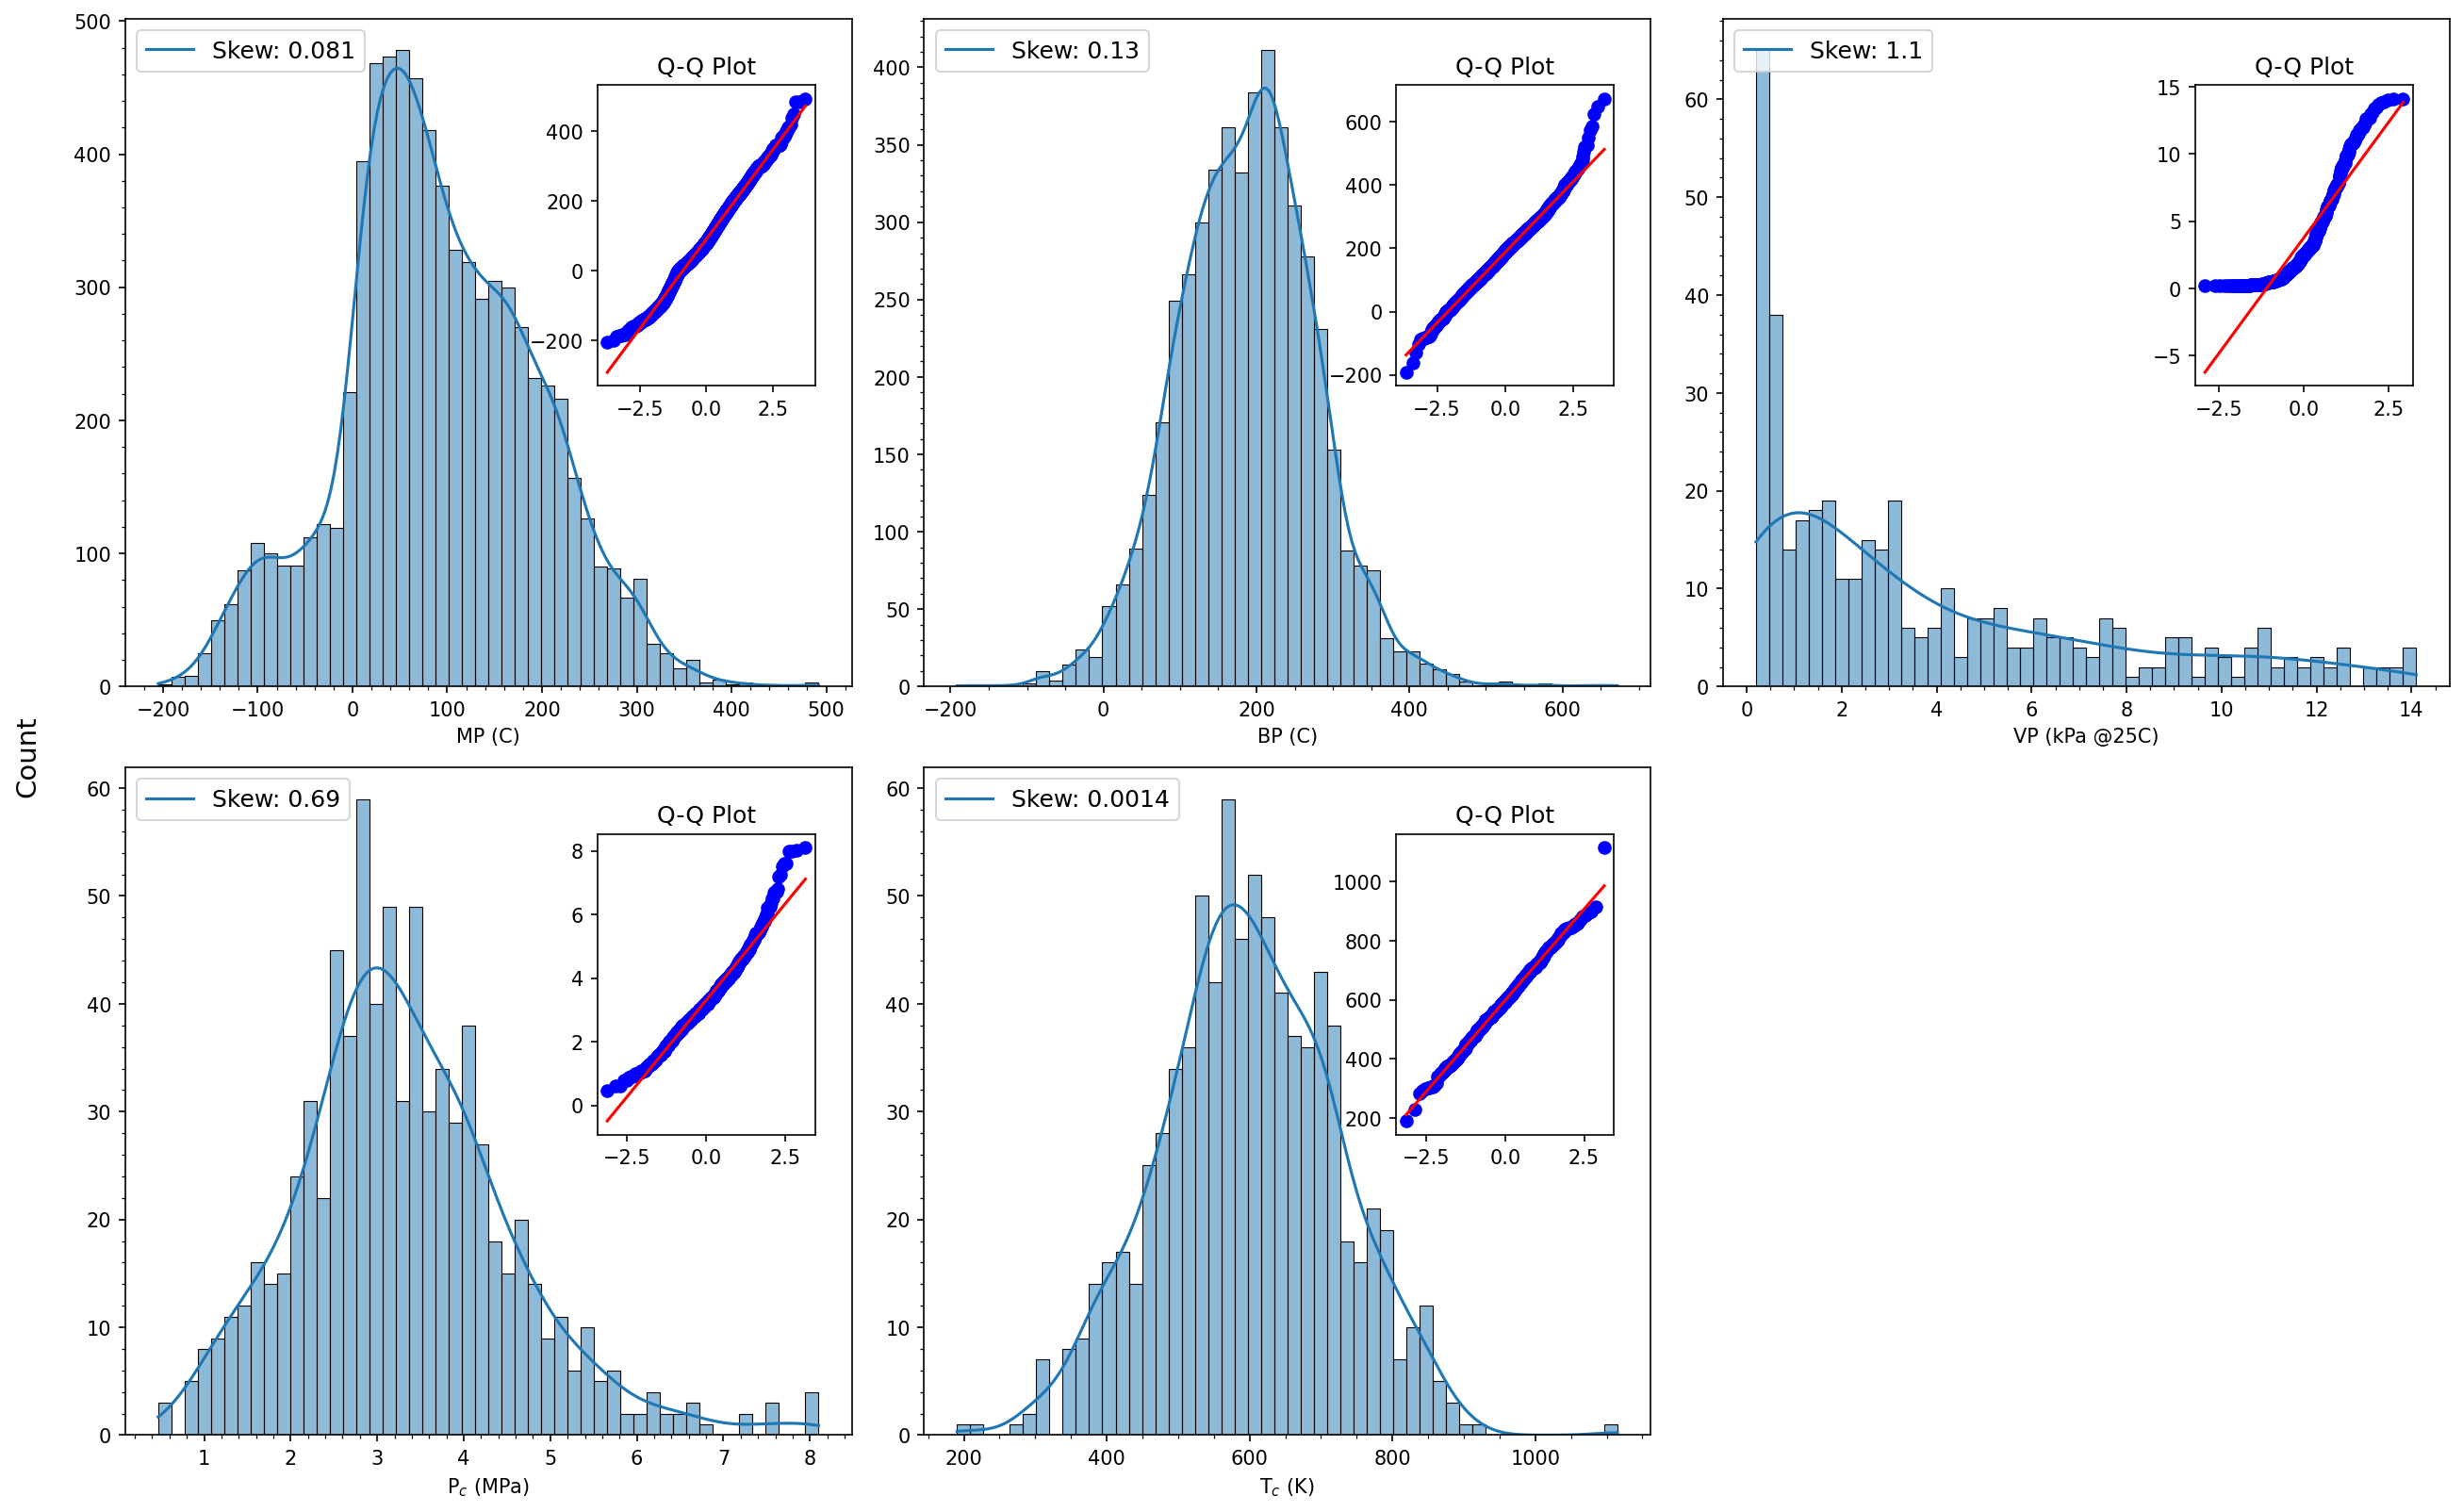

In [83]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    
    csv_file = data_dir.parent / (data_dir.name.replace('_processed_data', '') + '.csv')
    
    df = pd.read_csv(csv_file)
    y: pd.Series = None
    for col_name in df.columns:
        if col_name.startswith('Processed'):
            y = df[col_name]
            break
    
    if y is None:
        continue
    
    print(data_dir.name, y.shape, csv_file.name)
    
    # histplot with KDE
    sns.histplot(y, bins=50, kde=True, ax=axes[i])  
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('')
    # axes[i].set_title(titles[i], fontsize=14)
    axes[i].minorticks_on()
    
    # set skewness and kurtosis as legend
    skewness = y.skew()
    axes[i].legend([f'Skew: {sigfig.round(skewness, 2)}'], loc='upper left', fontsize=12)
    
    inset_ax = axes[i].inset_axes([0.65, 0.45, 0.3, 0.45])
    stats.probplot(y, dist="norm", plot=inset_ax)
    inset_ax.set_xlabel('')
    inset_ax.set_ylabel('')
    # inset_ax.set_title('')
    inset_ax.set_title('Q-Q Plot')
    
    
# Remove the last subplot (bottom-right) if it exists
if len(processed_data_dirs) < 6:
    fig.delaxes(axes[-1])

# Add common X and Y labels
# fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.savefig(plots_dir / 'y_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [85]:
sigfig.round(1.0123456789, 2)

1.0

tbp_topelements_processed_data gbr mol2vec_embeddings best_model
tbp_topelements_processed_data xgboost mol2vec_embeddings default
tbp_topelements_processed_data catboost mol2vec_embeddings default
tbp_topelements_processed_data lgbm mol2vec_embeddings default


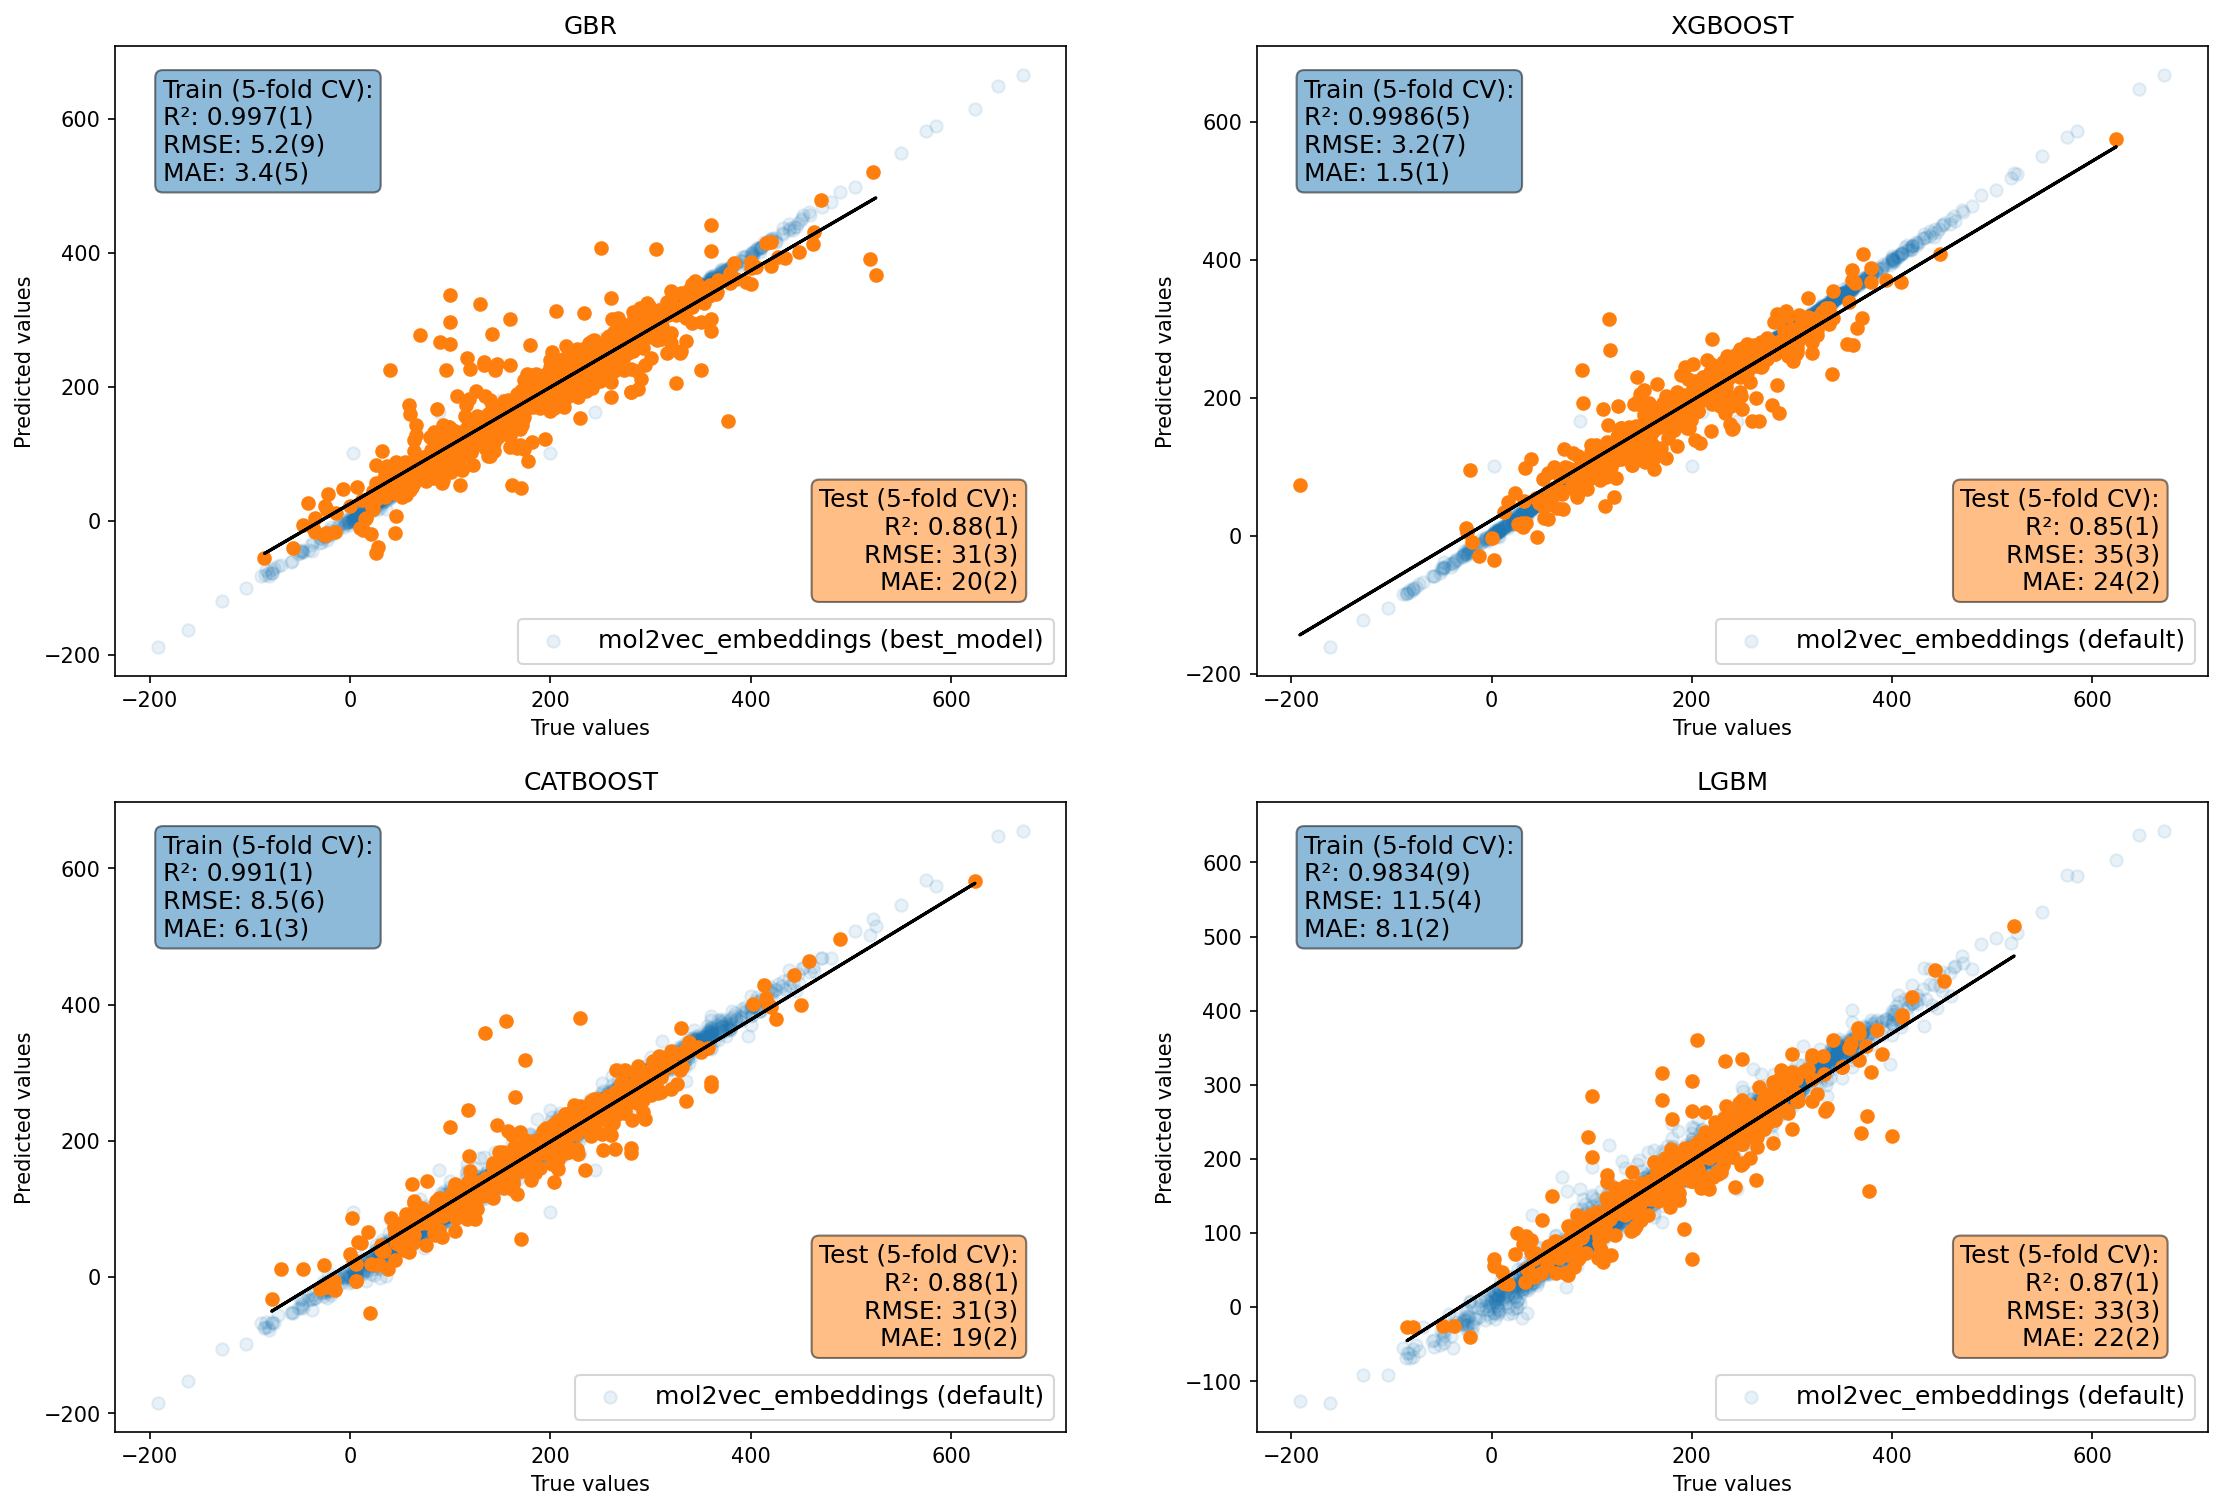

In [110]:

fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=150)
# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()
ind = 1
dir = processed_data_dirs[ind]

for i, model in enumerate(['gbr', 'xgboost', 'catboost', 'lgbm']):
    ax = axes[i]
    
    # model = 'lgbm'
    embeddings = 'mol2vec_embeddings'
    method = 'default'
    # method = 'best_model'
    if model == 'gbr':
        method = 'best_model'
    pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
    loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'

    print(dir.name, model, embeddings, method)
    
    resultsfile = loc / f'{pre_trained_filename}.results.json'
    datfile = loc / f'{pre_trained_filename}.dat.json'

    if not resultsfile.exists() or not datfile.exists():
        continue
    
    results = json.load(open(resultsfile, 'r'))
    data = json.load(open(datfile, 'r'))

    y_true_test = data["test"]["y_true"]
    y_pred_test = data["test"]["y_pred"]
    y_linear_fit_test = data["test"]["y_linear_fit"]

    y_true_train = data["train"]["y_true"]
    y_pred_train = data["train"]["y_pred"]
    # y_linear_fit_train = data["train"]["y_linear_fit"]

    # metrics = ["r2", "mse", "rmse", "mae"]
    metrics = ["r2", "rmse", "mae"]
    test_scores = {}
    train_scores = {}

    for v in ["test", "train"]:
        for k in metrics:
            mean = results["cv_scores"][v][k]["mean"]
            std = results["cv_scores"][v][k]["std"]
            if v == "test":
                test_scores[k] = sigfig.round(mean, std, sep="external_brackets")
            else:
                train_scores[k] = sigfig.round(mean, std, sep="external_brackets")

    # fig, ax = plt.subplots(2, 2)
    ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
    ax.scatter(y_true_test, y_pred_test, color="C1", label="Test")
    ax.plot(y_true_test, y_linear_fit_test, color="k")
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")

    # Add text annotations for metrics
    textstr_train = "\n".join(
        (
            f"Train ({results['cv_fold']}-fold CV):",
            f'R²: {train_scores["r2"]}',
            # f'MSE: {train_scores["mse"]}',
            f'RMSE: {train_scores["rmse"]}',
            f'MAE: {train_scores["mae"]}',
        )
    )

    textstr_test = "\n".join(
        (
            f"Test ({results['cv_fold']}-fold CV):",
            f'R²: {test_scores["r2"]}',
            # f'MSE: {test_scores["mse"]}',
            f'RMSE: {test_scores["rmse"]}',
            f'MAE: {test_scores["mae"]}',
        )
    )

    ax.text(
        0.05,
        0.95,
        textstr_train,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="C0", alpha=0.5),
    )
    ax.text(
        0.95,
        0.30,
        textstr_test,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="C1", alpha=0.5),
    )
    # ax.legend()
    ax.set_title(model.upper())
    ax.legend([f'{embeddings} ({method})'], fontsize=12)

# print(dir.name)
fig.savefig(plots_dir / f'{dir.name}_model_predictions.pdf', dpi=150, bbox_inches='tight')
plt.show()